In [1]:
!git clone https://github.com/jaddoescad/ants_and_bees

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 34.59 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision.utils import make_grid
from torchvision import datasets,transforms,models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
!ls ants_and_bees/

train  val


In [5]:
!ls ants_and_bees/train

ants  bees


In [6]:
!ls ants_and_bees/val

ants  bees


In [7]:
transform_train = transforms.Compose([  
                                      transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0,shear = 10, scale = (0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast = 1, saturation = 1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])
])

transform_test = transforms.Compose([
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
])

training_dataset = datasets.ImageFolder(root = "ants_and_bees/train", transform = transform_train)
validation_dataset = datasets.ImageFolder(root = "ants_and_bees/val", transform = transform_test)

In [8]:
training_loader = DataLoader(dataset = training_dataset,  batch_size = 20, shuffle = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 20, shuffle = False)

In [9]:
len(training_dataset),len(validation_dataset)

(244, 153)

In [10]:
len(training_dataset) / 20

12.2

In [11]:
len(training_loader),len(training_loader.dataset)

(13, 244)

In [30]:
def img_convert(tensor):

    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose((1,2,0))
    image = image*np.array([0.5,0.5,0.5]) + np.array([0.5,0.5,0.5])
    image = image.clip(0,1)

    return image

In [13]:
class_names = training_dataset.classes
class_names

['ants', 'bees']

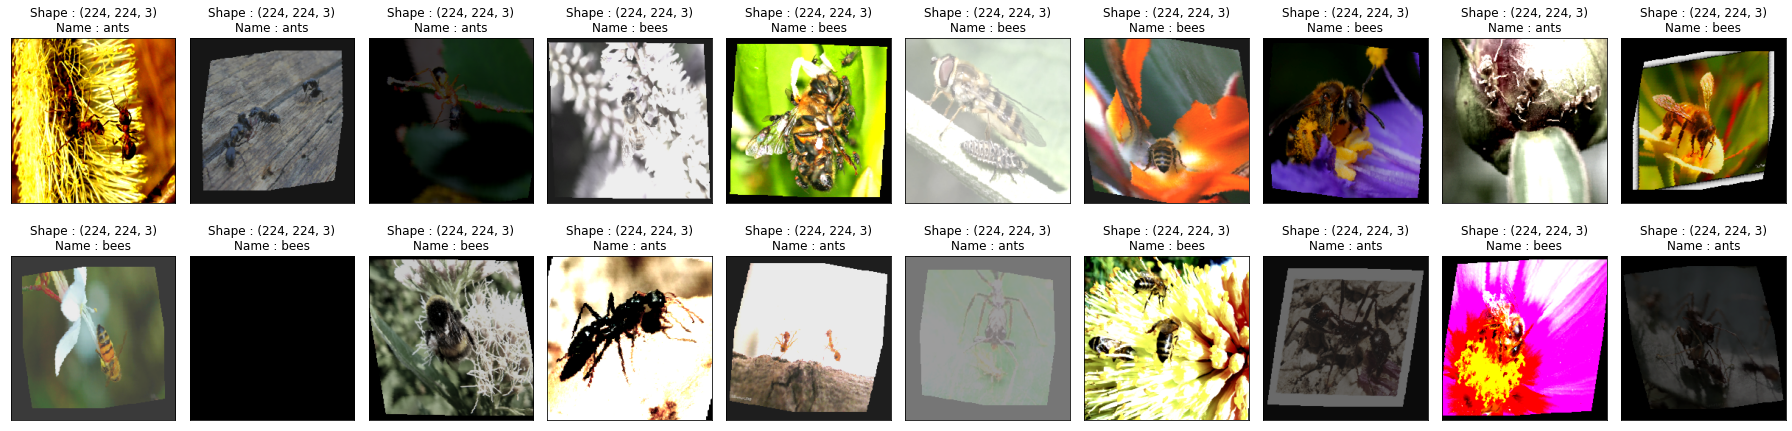

In [14]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize = (25,7))

for idx in np.arange(20):

    ax = fig.add_subplot(2,10,idx+1, xticks = [], yticks = [])
    convert = img_convert(images[idx])
    plt.imshow(convert)
    plt.title(f"Shape : {convert.shape}\nName : {class_names[labels[idx]]}")

    plt.tight_layout()
plt.show()

In [66]:
#model = models.alexnet(pretrained = True)
model = models.vgg16(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [67]:
for name,param in model.named_parameters():
    print(name, "\t", param.shape)
    print("".center(100, "-"))

features.0.weight 	 torch.Size([64, 3, 3, 3])
----------------------------------------------------------------------------------------------------
features.0.bias 	 torch.Size([64])
----------------------------------------------------------------------------------------------------
features.2.weight 	 torch.Size([64, 64, 3, 3])
----------------------------------------------------------------------------------------------------
features.2.bias 	 torch.Size([64])
----------------------------------------------------------------------------------------------------
features.5.weight 	 torch.Size([128, 64, 3, 3])
----------------------------------------------------------------------------------------------------
features.5.bias 	 torch.Size([128])
----------------------------------------------------------------------------------------------------
features.7.weight 	 torch.Size([128, 128, 3, 3])
--------------------------------------------------------------------------------------------------

In [68]:
for param in model.features.parameters():
    param.requeires_grad = False

In [69]:
n_inputs = model.classifier[6].in_features

last_layer = nn.Linear(n_inputs, len(class_names))

n_inputs, last_layer

(4096, Linear(in_features=4096, out_features=2, bias=True))

In [70]:
model.classifier[6] = last_layer
model.to(device)

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [72]:
import time

start_time = time.time()
epochs = 10

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for epoch in range(epochs):
    
    trn_loss = 0
    tst_loss = 0

    trn_corr = 0
    tst_corr = 0

    for b,(X_train, y_train) in enumerate(training_loader):

        b+=1

        inputs = X_train.to(device)
        y_train = y_train.to(device)

        outputs = model.forward(inputs)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_preds = torch.max(outputs, 1)[1]

        trn_loss +=loss.item()
        trn_corr +=(train_preds == y_train).sum()


    else:

        with torch.no_grad():

            for b,(X_test, y_test) in enumerate(validation_loader):

                b+=1

                val_inputs = X_test.to(device)
                y_test = y_test.to(device)

                val_outputs = model.forward(val_inputs)
                val_loss = criterion(val_outputs, y_test)

                test_preds = torch.max(val_outputs, 1)[1]

                tst_loss +=val_loss.item()
                tst_corr +=(test_preds == y_test).sum()
    
            train_loss = trn_loss / len(training_loader.dataset)
            train_corr = trn_corr.float() / len(training_loader.dataset)

            test_loss = tst_loss / len(validation_loader.dataset)
            test_corr = tst_corr.float() / len(validation_loader.dataset)

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            train_correct.append(train_corr)
            test_correct.append(test_corr)

            print()
            print("".center(100,"-"))
            print()
            print("Epoch : ", epoch+1)

            print("Training Loss : {:4.4f} , Training Accuracy : {:4.4f}".format(train_loss, train_corr) )
            print("Validation Loss : {:4.4f} , Validation Accuracy : {:4.4f}".format(test_loss , test_corr) )

            print()
            print("".center(100,"-"))
            print()


total_time = time.time() - start_time
print(f"\nDuration : {total_time} seconds....")


----------------------------------------------------------------------------------------------------

Epoch :  1
Training Loss : 0.0346 , Training Accuracy : 0.6066
Validation Loss : 0.0337 , Validation Accuracy : 0.6797

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------

Epoch :  2
Training Loss : 0.0298 , Training Accuracy : 0.7295
Validation Loss : 0.0157 , Validation Accuracy : 0.9150

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------

Epoch :  3
Training Loss : 0.0276 , Training Accuracy : 0.7254
Validation Loss : 0.0183 , Validation Accuracy : 0.8954

----------------------------------------------------------------------------------------------------


------------------------

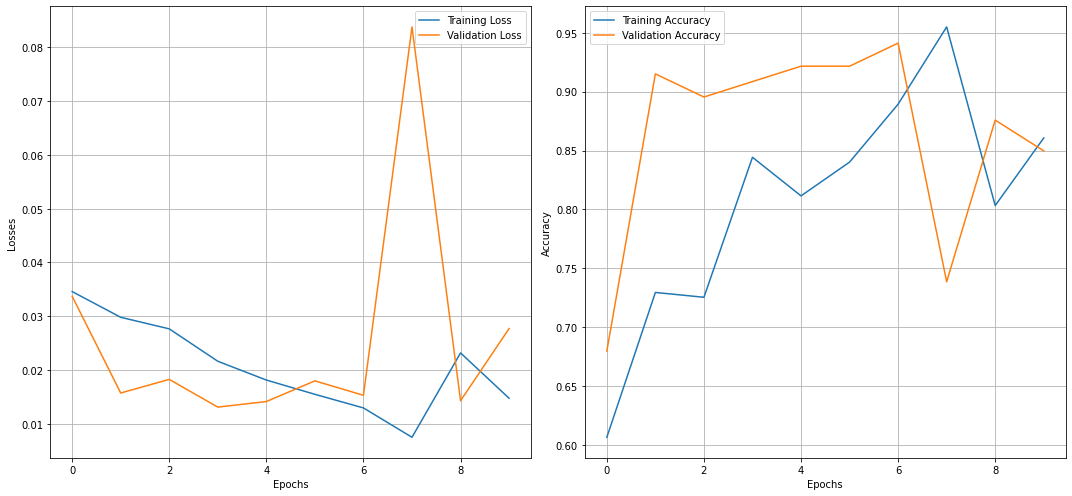

In [73]:
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.legend(loc = "best")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_correct, label = "Training Accuracy")
plt.plot(test_correct, label = "Validation Accuracy")
plt.legend(loc = "best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

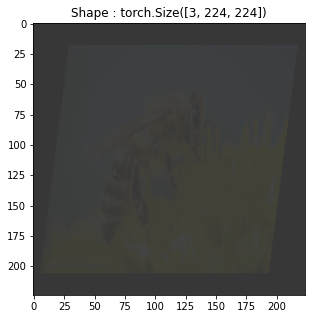

In [74]:
import requests
import PIL
from PIL import Image

#url = "https://c.files.bbci.co.uk/124C/production/_93648640_ant.jpg"
url = "https://m.bianet.org/system/uploads/1/articles/spot_image/000/224/562/original/ar%C4%B11.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
img = transform_train(img)

plt.figure(figsize = (12,5))
plt.imshow(img_convert(img))
plt.title(f"Shape : {img.shape}")
plt.show()

In [75]:
def predictions(image):

    with torch.no_grad():

        image = image.view(1,3,224,224)
        input = image.to(device)
        output = model.forward(input)
        pred = torch.max(output, 1)[1]

        return class_names[pred]

In [76]:
print("Predictions : " , predictions(img))

Predictions :  bees


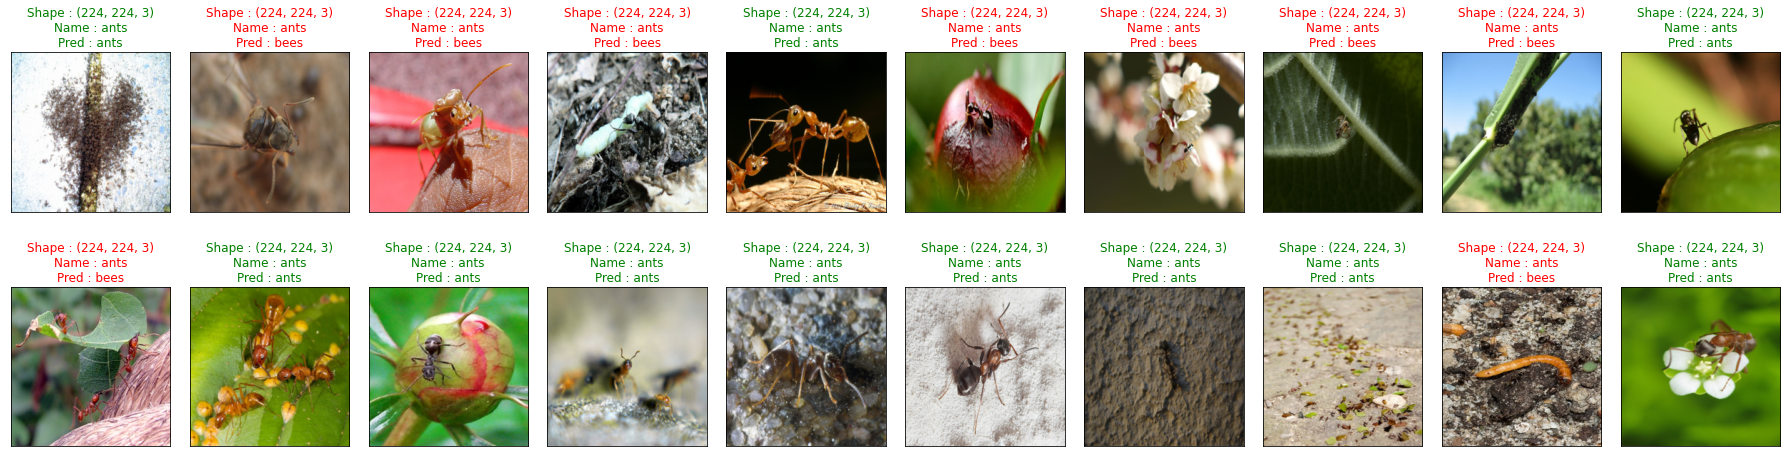

In [78]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize = (25,7))

for idx in np.arange(20):

    ax = fig.add_subplot(2,10,idx+1, xticks = [], yticks = [])
    convert = img_convert(images[idx])
    plt.imshow(convert)

    pred = predictions(images[idx])

    plt.title(f"Shape : {convert.shape}\nName : {class_names[labels[idx]]}\nPred : {pred}",
              color = ("green" if pred == class_names[labels[idx]] else "red"))

plt.tight_layout()
plt.show()